In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Import VGG16 and freeze all layers
vgg_model = torchvision.models.vgg16(pretrained=True)

for p in vgg_model.parameters():
    p.requires_grad = False

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 151MB/s]


In [3]:
#Put model on evaluation mode
vgg_model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [5]:
#Push model to GPU
vgg_model.to(device);

In [6]:
#Import 2 images
content_img = plt.imread('penguin.jpg')
style_img   = plt.imread('styleImage.png')

In [7]:
#Create target image using random no.s
target_img = np.random.randint(low = 0, high = 255, size = content_img.shape, dtype=np.uint8)

In [8]:
print(content_img.shape)
print(target_img.shape)
print(style_img.shape)

(1420, 1024, 3)
(1420, 1024, 3)
(159, 318, 3)


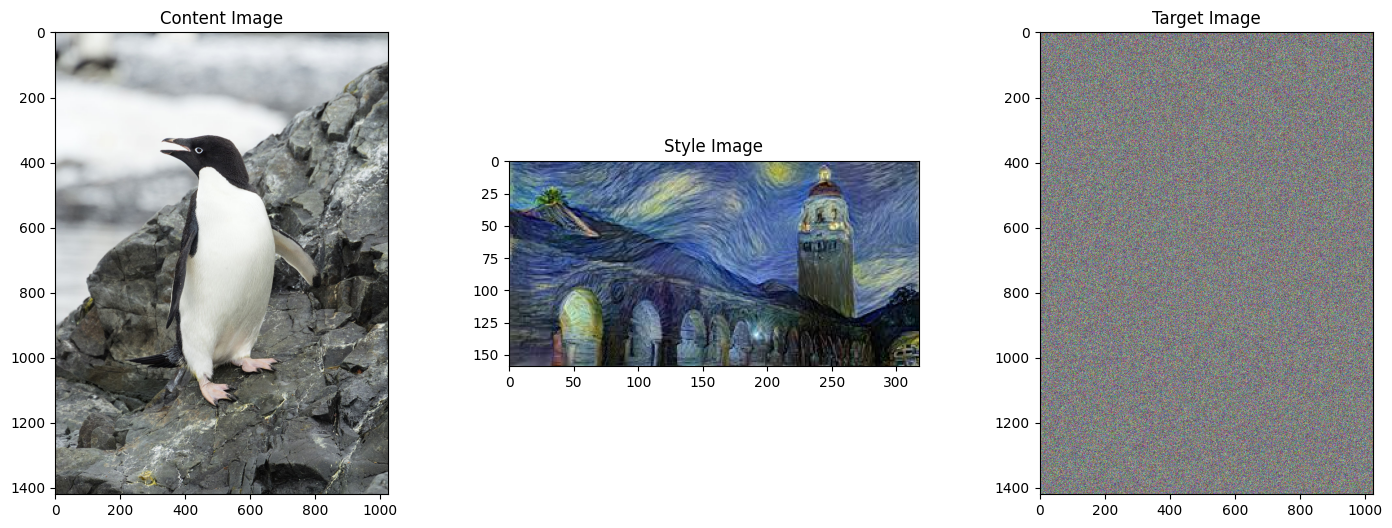

In [9]:
fig,ax = plt.subplots(1,3,figsize=(18,6))

ax[0].imshow(content_img)
ax[0].set_title('Content Image')

ax[1].imshow(style_img)
ax[1].set_title('Style Image')

ax[2].imshow(target_img)
ax[2].set_title('Target Image')

plt.show()

In [10]:
#Define transforms for the images
Transform = transforms.Compose([ transforms.ToTensor(),
                 transforms.Resize(256),
                 transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
               ])

In [11]:
#Apply the transofrms and convert to 4D data
content_img = Transform( content_img ).unsqueeze(0).to(device)
style_img   = Transform( style_img  ).unsqueeze(0).to(device)
target_img  = Transform( target_img  ).unsqueeze(0).to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:154: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


In [12]:
print(content_img.shape)
print(target_img.shape)
print(style_img.shape)

torch.Size([1, 3, 355, 256])
torch.Size([1, 3, 355, 256])
torch.Size([1, 3, 256, 512])


In [13]:
#Conetent Loss = MSE ( Target feature maps - content feature maps)

#Style Loss = MSE (Target Gram Matrix - Style Gram Matrix)

In [14]:
#Import functions for extracting features and creating gram matrix
from functions import Extract_FeatureMap, Gram_Matrix

In [15]:
# Apply Extract_FeatureMap function on content and style image

contentFeatureMaps,contentFeatureLayers = Extract_FeatureMap(content_img, vgg_model)

for i in range(len(contentFeatureLayers)):
  print('Feature map of "%s" is of size %s'%(contentFeatureLayers[i],(contentFeatureMaps[i].shape)))

Feature map of "ConvLayer_0" is of size torch.Size([1, 64, 355, 256])
Feature map of "ConvLayer_1" is of size torch.Size([1, 64, 355, 256])
Feature map of "ConvLayer_2" is of size torch.Size([1, 128, 177, 128])
Feature map of "ConvLayer_3" is of size torch.Size([1, 128, 177, 128])
Feature map of "ConvLayer_4" is of size torch.Size([1, 256, 88, 64])
Feature map of "ConvLayer_5" is of size torch.Size([1, 256, 88, 64])
Feature map of "ConvLayer_6" is of size torch.Size([1, 256, 88, 64])
Feature map of "ConvLayer_7" is of size torch.Size([1, 512, 44, 32])
Feature map of "ConvLayer_8" is of size torch.Size([1, 512, 44, 32])
Feature map of "ConvLayer_9" is of size torch.Size([1, 512, 44, 32])
Feature map of "ConvLayer_10" is of size torch.Size([1, 512, 22, 16])
Feature map of "ConvLayer_11" is of size torch.Size([1, 512, 22, 16])
Feature map of "ConvLayer_12" is of size torch.Size([1, 512, 22, 16])


In [16]:
styleFeatureMaps,styleFeatureLayers = Extract_FeatureMap(style_img,vgg_model)

for i in range(len(styleFeatureLayers)):
  print('Feature map of "%s" is of size %s'%(styleFeatureLayers[i],(styleFeatureMaps[i].shape)))

Feature map of "ConvLayer_0" is of size torch.Size([1, 64, 256, 512])
Feature map of "ConvLayer_1" is of size torch.Size([1, 64, 256, 512])
Feature map of "ConvLayer_2" is of size torch.Size([1, 128, 128, 256])
Feature map of "ConvLayer_3" is of size torch.Size([1, 128, 128, 256])
Feature map of "ConvLayer_4" is of size torch.Size([1, 256, 64, 128])
Feature map of "ConvLayer_5" is of size torch.Size([1, 256, 64, 128])
Feature map of "ConvLayer_6" is of size torch.Size([1, 256, 64, 128])
Feature map of "ConvLayer_7" is of size torch.Size([1, 512, 32, 64])
Feature map of "ConvLayer_8" is of size torch.Size([1, 512, 32, 64])
Feature map of "ConvLayer_9" is of size torch.Size([1, 512, 32, 64])
Feature map of "ConvLayer_10" is of size torch.Size([1, 512, 16, 32])
Feature map of "ConvLayer_11" is of size torch.Size([1, 512, 16, 32])
Feature map of "ConvLayer_12" is of size torch.Size([1, 512, 16, 32])


In [17]:
#Select layers for neural style transfer
content_layers = [ 'ConvLayer_1','ConvLayer_4' ]
style_layers   = [ 'ConvLayer_1','ConvLayer_2','ConvLayer_3','ConvLayer_4', 'ConvLayer_7','ConvLayer_8','ConvLayer_9' ]
style_weights  = [      1       ,     .5      ,     .5      ,     .2      ,     .1       ,   .1       ,     .2       ]

In [18]:
#Train
target = target_img.clone()
target.requires_grad = True  # back propagation is applied only on target images
target = target.to(device)
style_weighting = 1e6 # styleloss and content loss are of different scale so need scaling

epochs = 1501

optimizer = torch.optim.RMSprop([target],lr = 0.005) # RMS prop because it is recommended. Only target image for back propagation.


for epoch in range(epochs):

  # Extract the target feature maps
  targetFeatureMaps,targetFeatureLayers = Extract_FeatureMap(target,vgg_model)


  # Initialize the individual losses

  styleLoss = 0
  contentLoss = 0

  for layeri in range(len(targetFeatureLayers)):


    # Compute the content loss
    if targetFeatureLayers[layeri] in content_layers:
      contentLoss += torch.mean( (targetFeatureMaps[layeri]-contentFeatureMaps[layeri])**2 ) # MSE loss for content


    # Compute the style loss
    if targetFeatureLayers[layeri] in style_layers:

      # Compute Gram matrices
      Gram_target = Gram_Matrix(targetFeatureMaps[layeri])
      Gram_style  = Gram_Matrix(styleFeatureMaps[layeri])

      styleLoss += torch.mean( (Gram_target-Gram_style)**2 ) * style_weights[style_layers.index(targetFeatureLayers[layeri])]
        # MSE LOSS AND WEIGHTING FOR STYLE LOSS.


  # Accumulate loss
  combined_loss = style_weighting * styleLoss + contentLoss


  optimizer.zero_grad()
  combined_loss.backward()
  optimizer.step()

  # printing the epochs
  if (epoch)%100==0:
    print(f' Epochs : {epoch}/{epochs}')

 Epochs : 0/1501
 Epochs : 100/1501
 Epochs : 200/1501
 Epochs : 300/1501
 Epochs : 400/1501
 Epochs : 500/1501
 Epochs : 600/1501
 Epochs : 700/1501
 Epochs : 800/1501
 Epochs : 900/1501
 Epochs : 1000/1501
 Epochs : 1100/1501
 Epochs : 1200/1501
 Epochs : 1300/1501
 Epochs : 1400/1501
 Epochs : 1500/1501


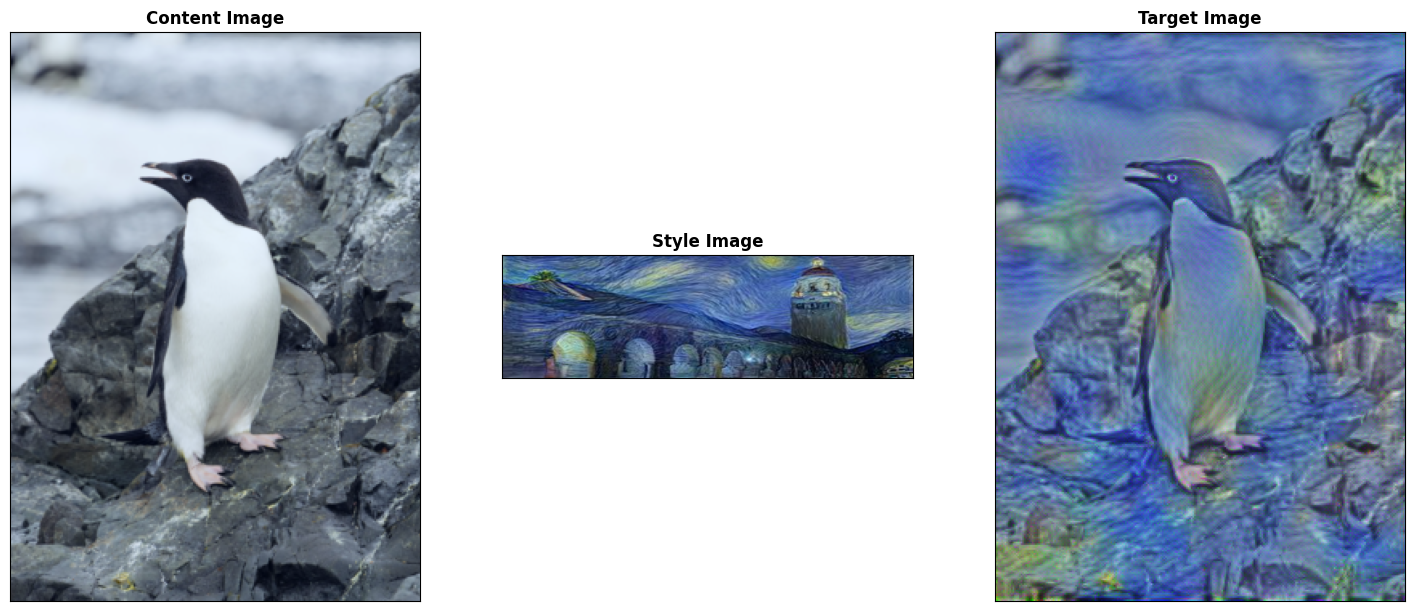

In [19]:
#Check the performance

fig,ax = plt.subplots(1,3,figsize=(18,11))

pic = content_img.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content Image',fontweight='bold')
ax[0].set_xticks([])
ax[0].set_yticks([])

pic = style_img.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[1].imshow(pic,aspect=.6)
ax[1].set_title('Style Image',fontweight='bold')
ax[1].set_xticks([])
ax[1].set_yticks([])

pic = torch.sigmoid(target).cpu().detach().squeeze().numpy().transpose((1,2,0))
ax[2].imshow(pic)
ax[2].set_title('Target Image',fontweight='bold')
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()